# Code for figures in problem a)

In this notebook we do experiments with minimising OLS and Ridge cost functions for the Franke function for different methods and hyperparametres

In [1]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

# Import split and MSELoss. All descent methods.
from Code.utilities import train_test_split, MSELoss_method
from Code.descent_methods import *

# Import tools from the first project. Feature matrix, sampling and scaling
from Code.project1_tools import feature_matrix_2d, r2_sampling, scale_feature_matrix

# lines used for nice legend, ticker for x and y axis ticks, seaborn for grid search, pandas for nice datastorage. Numpy. jax jit to speed up
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import pandas as pd
import numpy as np
from jax import jit

# Timing methods
import time as time

# Import the gradient methods. Assign colors for plots comparing them ...
from Code.utilities import OLS_train_analgrad, OLS_train_autograd, ridge_train_analgrad, ridge_train_autograd

methods_dict_list = [{"name"   : "GD",       "method" : GD,           "color" : "C0"},
                     {"name"   : "SGD",      "method" : SGD,          "color" : "C1"},
                     {"name"   : "adagrad",  "method" : SGD_adagrad,  "color" : "C2"},
                     {"name"   : "RMS prop", "method" : SGD_RMS_prop, "color" : "C3"},
                     {"name"   : "adam",     "method" : SGD_adam,     "color" : "C4"}]

# Set the default font size for text elements (e.g., titles, labels)
sns.set() # default from sns is pretties (:
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'

# Set filename start. Create the folder if gone
filepath_location = "Figures/a/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

### Initialisation

In [2]:
### Fix a seed for sampling and initialisation to get consistent results
np.random.seed(41)

# Initialise beta
num_features = 10

# Start with small values
beta0 = {"b" : np.random.random(num_features)*0.1}

# Sample points and split in train and test
num_points = 100
split=0.2
data = r2_sampling(num_points)
x, y, z = data["x"], data["y"], data["z"]

# Scaling etc
X = feature_matrix_2d(x, y, num_features)
X, means, var = scale_feature_matrix(X)
X_train, y_train, X_test, y_test, test_index = train_test_split(X, z, split)

# Squeeze to avoid errors due to shape [100, 1]
y_train, y_test = np.squeeze(y_train), np.squeeze(y_test)

# Define the polynomial fit model. Define corresponding loss function
def model(beta, X):
    return jnp.dot(X, beta["b"])

loss_func = jit(MSELoss_method(model))

# Update filename string with parameters that are not experimented with below
filepath_location_default = filepath_location + f"deg={num_features}_N={num_points}_split={split}"

### Comparing the 4 gradients

OLS analytic: 0.8 s
OLS automatic: 0.7 s
Ridge analytic: 0.95 s
Ridge automatic: 0.7 s


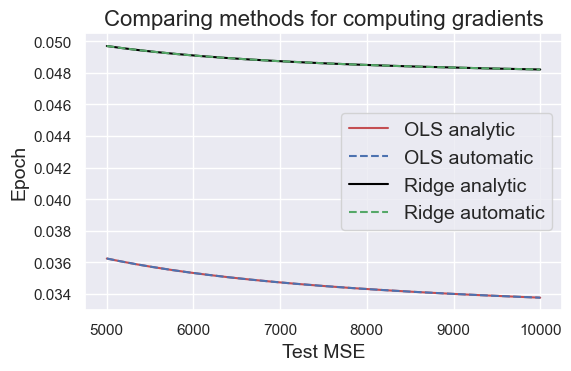

In [3]:
def gradient_comparison_experiment(method=GD, savefig=False, n_epochs=10000):
    
    # Get method name
    method_name = next(item["name"] for item in methods_dict_list if item["method"] == method)
    
    # Use even number for epochs. Initialise test parameters
    lam=0.1
    lr = 0.05

    # Make plot
    fig, ax = plt.subplots(figsize=(6, 4))

    # Loop
    linestyles = ["r", "b--", "black", "g--"]
    labels = ["OLS analytic", "OLS automatic", "Ridge analytic", "Ridge automatic"]
    for i, loss_grad in enumerate([OLS_train_analgrad(model), jit(OLS_train_autograd(model)), 
                                   ridge_train_analgrad(model, lam), jit(ridge_train_autograd(model, lam))]):

        # Time the run
        t0 = time.time()
        result_GD = method(X_train, y_train, X_test, y_test, 
                    grad_method=loss_grad, 
                    n_epochs=n_epochs, 
                    lr=lr,
                    beta0=beta0, 
                    test_loss_func=(jit(MSELoss_method(model))))
        print(f"{labels[i]}: {round(time.time()-t0, 2)} s")

        # Plot the second half of training
        plt.plot(np.arange(n_epochs//2, n_epochs+1, 1), result_GD["test_loss_list"][n_epochs//2::], linestyles[i], label=labels[i])

    plt.title("Comparing methods for computing gradients")
    plt.xlabel("Test MSE")
    plt.ylabel("Epoch")
    plt.legend()
    plt.tight_layout()
    if savefig:
        plt.savefig(filepath_location_default+f"__gradient_comparison__lr={lr}_lam={lam}_method={method_name}.png")  
    plt.show()

gradient_comparison_experiment(savefig=True)

See that anal and auto give same results. Thanks to JIT runtime is the same. We use analytic in the following!

### Testing momentum 

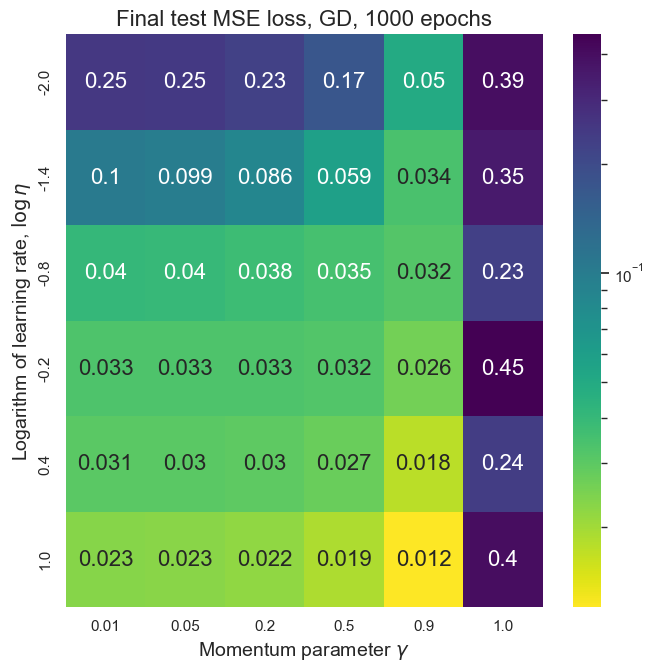

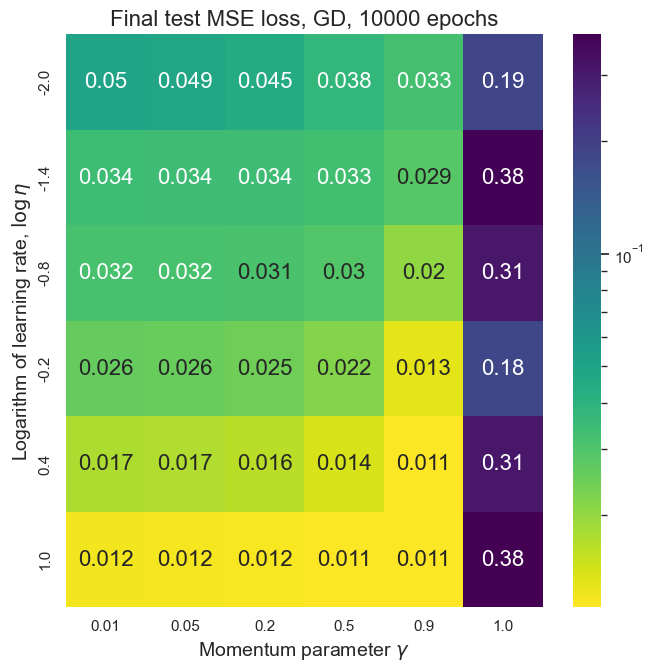

In [4]:
def lr_momentum_experiment(method, epochs=1000, savefig=False):

    # Get method name
    method_name = next(item["name"] for item in methods_dict_list if item["method"] == method)

    # Ensure results don't change on rerun
    np.random.seed(0)

    # Values for experiment
    lr_vals = np.logspace(-2, 1, 6)
    gamma_vals = np.array([0.01, 0.05, 0.2, 0.5, 0.9, 1])
    results = np.zeros((len(lr_vals), len(gamma_vals)))

    # We juse analytic OLS
    grad_method= OLS_train_analgrad(model)

    # Perform algorithm for each value
    for i, lr in enumerate(lr_vals):
        for j, gamma in enumerate(gamma_vals):

            # Perform experiment
            result_GD = method(X_train, y_train, X_test, y_test, 
                        grad_method=grad_method, 
                        n_epochs=epochs, 
                        lr=lr,
                        beta0=beta0, 
                        gamma=gamma,
                        test_loss_func=loss_func)

            # Append the final error from training
            results[i, j] = result_GD["test_loss_list"][-1]

    # Make plot
    fig, ax = plt.subplots(figsize = (7, 7))
    sns.heatmap(results, annot=True, ax=ax, cmap="viridis_r", norm="log")
    ax.set_title(f"Final test MSE loss, {method_name}, {epochs} epochs")

    # Handle labels
    ax.set_xlabel("Momentum parameter $\gamma$")
    ax.set_ylabel("Logarithm of learning rate, $\log{\eta}$")
    
    ax.set_xticklabels(np.round(gamma_vals, 2))
    ax.set_yticklabels(np.round(np.log10(lr_vals), 2))

    # Save and show    
    plt.tight_layout()
    if savefig:
        plt.savefig(filepath_location_default+f"__lr&momentum_eperiment__epochs={epochs}__method={method_name}.png")  
    plt.show()

lr_momentum_experiment(GD, savefig=True, epochs=1000)
lr_momentum_experiment(GD, savefig=True, epochs=10000)
# lr_momentum_experiment(SGD, savefig=True, epochs=100)
# lr_momentum_experiment(SGD, savefig=True, epochs=1000)
# lr_momentum_experiment(SGD_adagrad, savefig=True)
# lr_momentum_experiment(SGD_RMS_prop, savefig=True)
# lr_momentum_experiment(SGD_adam, savefig=True, epochs=10)
# lr_momentum_experiment(SGD_adam, savefig=True, epochs=100)

Here: discuss how gamma=1 results in "shift". Interpretation: here stack up all previous gradients. For gamma<1 we dampen the first... For gamma>1, would get exponential...

### Comparing the methods for different number of epochs

Final error for GD = 0.25397419929504395
Final error for SGD = 0.03623484447598457
Final error for adagrad = 0.03254251927137375
Final error for RMS prop = 0.020224427804350853
Final error for adam = 0.014159426093101501


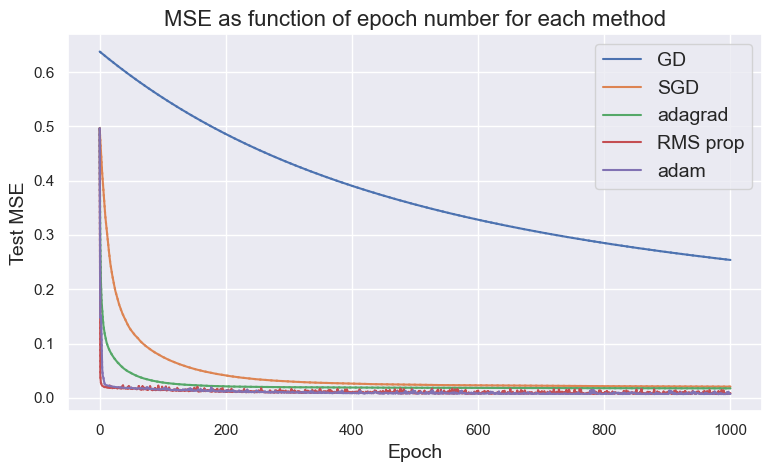

In [13]:
## We compare final train error to see "how far convergence has come"
def epoch_experiment(lr, n_epochs=1000, methods_dict_list=methods_dict_list, save=False):

    # Use OLS analytic
    loss_grad = OLS_train_analgrad(model)

    # For methods with n_batches, the default 5 is used!
    n_batches = 5

    fig, ax = plt.subplots(figsize=(8, 5))

    for method_dict in methods_dict_list:

        method_func = method_dict["method"]
        method_name = method_dict["name"]
        method_col  = method_dict["color"]

        result = method_func(X_train, y_train, X_test, y_test, 
                grad_method=loss_grad, 
                n_epochs=n_epochs, 
                lr=lr,
                beta0=beta0, 
                test_loss_func=(MSELoss_method(model)))
            
        if method_name=="GD": # batch size 1
            plt.plot(result["test_loss_list"][::1], label=method_name, color=method_col)
            plt.plot(result["test_loss_list"][::1], color=method_col, linestyle="dotted")
        else:
            plt.plot(result["train_loss_list"][::n_batches], label=method_name, color=method_col)
            plt.plot(result["train_loss_list"][::n_batches], color=method_col, linestyle="dotted")
        print(f"Final error for {method_name} = {result['test_loss_list'][-1]}")

    plt.xlabel("Epoch")
    plt.ylabel("Test MSE")
    plt.title("MSE as function of epoch number for each method")

    plt.tight_layout()
    plt.legend()
    plt.savefig(filepath_location_default+f"__epoch_eperiment__lr={lr}.png")    
    plt.show()

# epoch_experiment(0.001)
epoch_experiment(0.01, save=True)
# epoch_experiment(0.1)

### Learning rate experiment

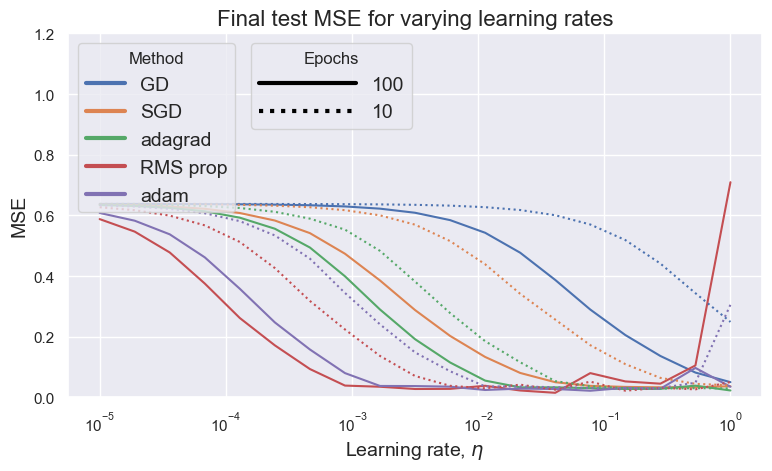

In [9]:
# We compare final train error to see "how far convergence has come"
# Define experiment. This one alters the current plot
def lr_experiment(lr_values, n_epochs=3, methods_dict_list=methods_dict_list, linestyle='solid'):

    # For methods with n_batches, the default 5 is used!
    n_batches = 5

    # Use OLS analytic
    loss_grad = OLS_train_analgrad(model)

    # Perform experiment for each method
    for method_dict in methods_dict_list:

        # Get name and method
        method_func = method_dict["method"]
        method_name = method_dict["name"]

        # Storage for errors
        final_errors = []

        # Do experiment for each learning rate
        for lr in lr_values:

            result = method_func(X_train, y_train, X_test, y_test, 
                    grad_method=loss_grad, 
                    n_epochs=n_epochs, 
                    lr=lr,
                    beta0=beta0, 
                    test_loss_func=(MSELoss_method(model)),
                    n_batches=n_batches)
            
            final_errors.append(result["test_loss_list"][-1])

        plt.plot(lr_values, final_errors, label=method_name, color=method_dict["color"], linestyle=linestyle)

# Init
fig, ax = plt.subplots(figsize=(8, 5))

# Values for the learning rates
lr_values = np.logspace(-5, 0, 19)

# Colors for legend
colors = [meth["color"] for meth in methods_dict_list]
meth_names = [meth["name"] for meth in methods_dict_list]

# Linestyles for legend
epoch_nums = [100, 10]
line_styles = ["solid", "dotted", "dashed", "dashdot"]
names = [f"{n}" for n in epoch_nums]

# A nice seed. Do all the experiments
np.random.seed(35)
for i in range(len(epoch_nums)):
    lr_experiment(lr_values, n_epochs=epoch_nums[i], linestyle=line_styles[i])

# Create custom handles for the legend, create two legends, one for color and one for line style
color_handles = [Line2D([0], [0], color=c, lw=3) for c in colors]
style_handles = [Line2D([0], [0], color='black', lw=3, linestyle=ls) for ls in line_styles]
legend_color = plt.legend(color_handles, meth_names, loc='upper left', title='Method', bbox_to_anchor=(0,1))
legend_style = plt.legend(style_handles, epoch_nums, loc='upper left', title='Epochs', bbox_to_anchor=(0.25,1), handlelength=5)

# Labels and title
plt.xlabel(r"Learning rate, $\eta$")
plt.xscale("log")
plt.ylabel("MSE")
plt.title("Final test MSE for varying learning rates")
plt.ylim(0, 1.2)

# Add the first legend manually to the plot
plt.gca().add_artist(legend_color)
plt.tight_layout()
plt.savefig(filepath_location_default+f"__lr_eperiment__.png")
plt.show()


### Mini batches

We now se how the performance of the 4 stochastic descent methods depend on the number of minibatches

C:\Users\Eirik\AppData\Local\Temp\ipykernel_162708\2406473293.py:67: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


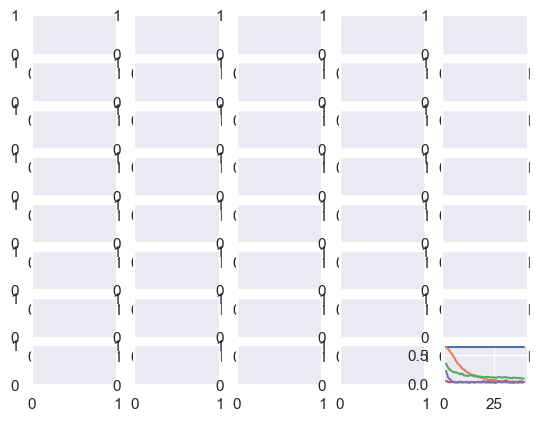

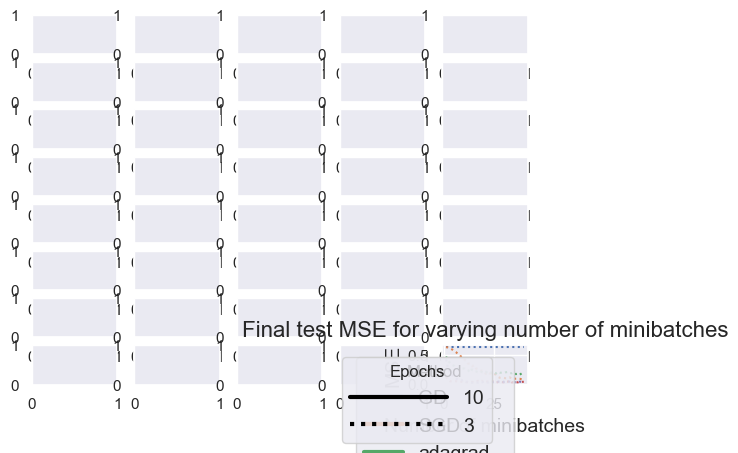

In [10]:
# We compare final train error to see "how far convergence has come"
# Define experiment. This one alters the current plot
def minibatch_experiment(n_minibatch_values, lr=0.01, n_epochs=3, methods_dict_list=methods_dict_list, linestyle='solid'):

    # Use OLS analytic
    loss_grad = OLS_train_analgrad(model)

    fig, ax = plt.subplots(figsize=(8, 5))

    # Perform experiment for each method
    for method_dict in methods_dict_list:

        # Get name and method
        method_func = method_dict["method"]
        method_name = method_dict["name"]

        # Storage for errors
        final_errors = []

        # Do experiment for each learning rate
        for n_minibatch in n_minibatch_values:

            result = method_func(X_train, y_train, X_test, y_test, 
                    grad_method=loss_grad, 
                    n_epochs=n_epochs,
                    lr=lr,
                    n_batches=n_minibatch,
                    beta0=beta0, 
                    test_loss_func=(MSELoss_method(model)))
            
            final_errors.append(result["test_loss_list"][-1])

        plt.plot(n_minibatch_values, final_errors, label=method_name, color=method_dict["color"], linestyle=linestyle)

# Values for the learning rates
n_minibach_values = [i for i in range(1, 1+40)]

# Colors for legend
colors = [meth["color"] for meth in methods_dict_list]
meth_names = [meth["name"] for meth in methods_dict_list]

# Linestyles for legend
epoch_nums = [10, 3]
line_styles = ["solid", "dotted", "dashed", "dashdot"]
names = [f"{n}" for n in epoch_nums]

# A nice seed. Do all the experiments
np.random.seed(35)
for i in range(len(epoch_nums)):
    minibatch_experiment(n_minibach_values, n_epochs=epoch_nums[i], linestyle=line_styles[i])

# Create custom handles for the legend, create two legends, one for color and one for line style
color_handles = [Line2D([0], [0], color=c, lw=3) for c in colors]
style_handles = [Line2D([0], [0], color='black', lw=3, linestyle=ls) for ls in line_styles]
legend_color = plt.legend(color_handles, meth_names, loc='upper right', title='Method', bbox_to_anchor=(0.95,0.95))
legend_style = plt.legend(style_handles, epoch_nums, loc='upper right', title='Epochs', bbox_to_anchor=(0.7,0.95), handlelength=5)

# Labels and title
plt.xlabel(r"Number of minibatches")
plt.ylabel("MSE")
plt.title("Final test MSE for varying number of minibatches")

# Add the first legend manually to the plot
plt.gca().add_artist(legend_color)

# Save
plt.tight_layout()
plt.savefig(filepath_location_default+f"__minibatch_eperiment__.png")
plt.show()

Diskusjon. Lurt å velge 5-10 for adam selvom litt mindre feil senere. Årsak: koster å gå inn i gradientberegning, så man må *strike a balance*

### Seaborn Ridge
Ridge as function of learning rate and lambda

use seabord ... to show results as function of lr and lam !


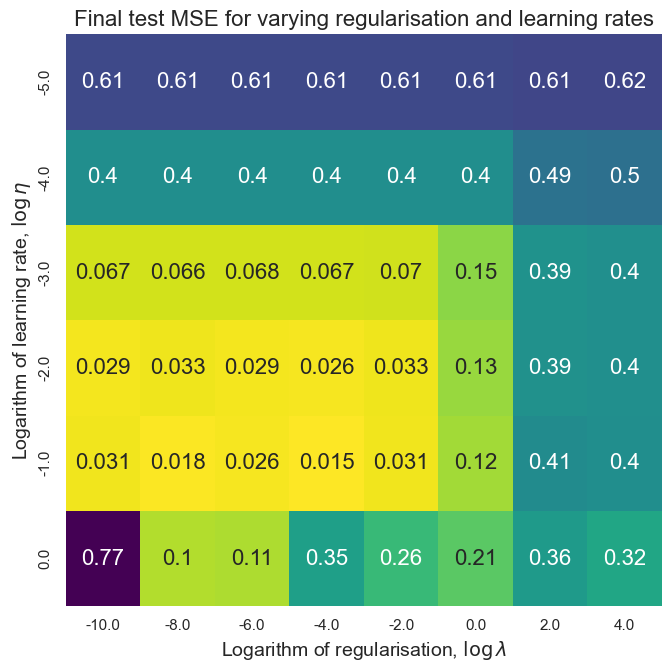

In [11]:
def ridge_experiment(lr_vals = np.logspace(-6, 1, 6), lam_vals = np.logspace(-10, 10, 6), savefig=False):
    # ensure the same random numbers appear every time
    np.random.seed(1)

    # Fixed parametres
    epochs = 100

    # Values for experiment
    lr_vals = np.logspace(-5, 0, 6)
    lam_vals = np.logspace(-10, 4, 8)
    results = np.zeros((len(lr_vals), len(lam_vals)))

    # We juse analytic ridge
    train_grad = ridge_train_analgrad

    # Perform algorithm for each value
    for i, lr in enumerate(lr_vals):
        for j, lam in enumerate(lam_vals):

            # Get gradient function for given lambda
            grad_method = train_grad(model, lam)

            # Perform experiment
            result = SGD_adam(X_train, y_train, X_test, y_test, 
                        grad_method=grad_method, 
                        n_epochs=epochs, 
                        n_batches=5,
                        lr=lr,
                        beta0=beta0, 
                        test_loss_func=loss_func)

            # Append the final error from training
            results[i, j] = result["test_loss_list"][-1]

    # Make sns heatmap
    fig, ax = plt.subplots(figsize = (7, 7))
    sns.heatmap(results, annot=True, ax=ax, cmap="viridis_r", cbar=False)

    # Title
    ax.set_title("Final test MSE for varying regularisation and learning rates")

    # Handle labels
    ax.set_xlabel("Logarithm of regularisation, $\log\lambda$")
    ax.set_ylabel("Logarithm of learning rate, $\log{\eta}$")

    ax.set_xticklabels(np.round(np.log10(lam_vals), 2))
    ax.set_yticklabels(np.round(np.log10(lr_vals), 2))

    # Save/show
    plt.tight_layout()
    if savefig:
        plt.savefig(filepath_location_default+f"__ridge_eperiment__epochs={epochs}.png")
    plt.show()

ridge_experiment(savefig=True)